In [1]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import RetrievalQA
from langchain_community.llms import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score
import logging
import pickle
from ragatouille import RAGPretrainedModel

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

## Helpers

In [2]:
retrieval_strategy = "colbert"
model = "llama-2-13b-chat.Q4_K_M"

persist_directory = "./../embeddings"
index_root = "./../colbert_index/"
colbert_path = "./../colbertv2.0/"
index_path = "./../colbert_index/colbert/indexes/documents/"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        # self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        # self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses

    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Colbert Retriever

In [5]:
RAG = RAGPretrainedModel.from_index(index_path=index_path)

[Apr 16, 18:59:24] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


In [6]:
retriever = RAG.as_langchain_retriever(k=5)

## Quantized Model

In [7]:
# For this evaluation, we are using an OpenAI-compatible endpoint running in LM Studio
# on a MacBook Pro with an M1 Pro chip.

llm_open = OpenAI(
    openai_api_base="http://localhost:1234/v1",
    openai_api_key="hello",
    temperature=0.15,
    top_p=1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [8]:
from langchain_core.prompts import PromptTemplate

template = """
Use only the following pieces of context to answer the question at the end. 
Keep your answers concise and do not provide additional explanations or interpretations. 
If the answer cannot be deduced from the context, just say that you don't know the answer, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:
"""

In [9]:
qa_chain = RetrievalQA.from_chain_type(
    # qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template, input_variables=["context", "question"]
        )
    },
)

In [10]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)



> Entering new RetrievalQA chain...
Loading searcher for index documents for the first time... This may take a few seconds
[Apr 16, 18:59:38] #> Loading codec...
[Apr 16, 18:59:38] #> Loading IVF...
[Apr 16, 18:59:38] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Apr 16, 18:59:38] #> Loading doclens...


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1031.05it/s]

[Apr 16, 18:59:38] #> Loading codes and residuals...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]

[Apr 16, 18:59:38] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Apr 16, 18:59:39] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Which class involves time series analysis?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2029, 2465, 7336, 2051, 2186, 4106, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Syllabus SIADS 632: Data Mining II Course Overview And Prerequisites
2. Data Mining II (SIADS 632): Learning Outcomes
3. Data Science for Social Good (SIADS 688): Learning Outcomes
4. Causal Inference (SIADS 630): Course Schedule
5. Network Analysis

## Run the Model

In [11]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [12]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [ ]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", "wb") as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "wb") as handle:
        pickle.dump(formatter.get_responses(), handle)

## Evaluation with BERTScore

In [13]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [14]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
  Sure! Based on the information provided, the answer to the question "Which class involves time series analysis?" is:

Data Mining II (SIADS 632).


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the instructor of the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------


In [15]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1,  # 'Which class involves time series analysis?',
    1,  # 'Who teaches the SQL and Databases class?',
    0,  # 'What are the prerequisites for Data Science for Social Good?',
    0,  # 'When are the office hours for the Math Methods course?',
    1,  # 'Are there any weekly readings for Milestone II?',
    1,  # 'What are the outcomes of Qualitative Inquiry?',
    1,  # 'What textbook is required for SIADS 505?',
    1,  # 'What textbook is required for Data Manipulation?',
    1,  # 'Which week of unsupervised learning covers DBSCAN?',
    1,  # 'How many credits are required to complete the MADS program?',
    1,  # 'How long do students have to complete the MADS program start to finish?',
    1,  # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1,  # 'What is the penalty for late submission in SIADS 630?',
    1,  # 'How do I get accommodations for a class?',
    1,  # 'What is a backpack?',
    1,  # 'When is the latest I can drop a course?',
    1,  # 'How do I get an override to take a class?',
    1,  # 'How do I take a leave of absence from the MADS program?',
    1,  # 'What are the prerequisites for Search and Recommender Systems?'
]

In [16]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [17]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

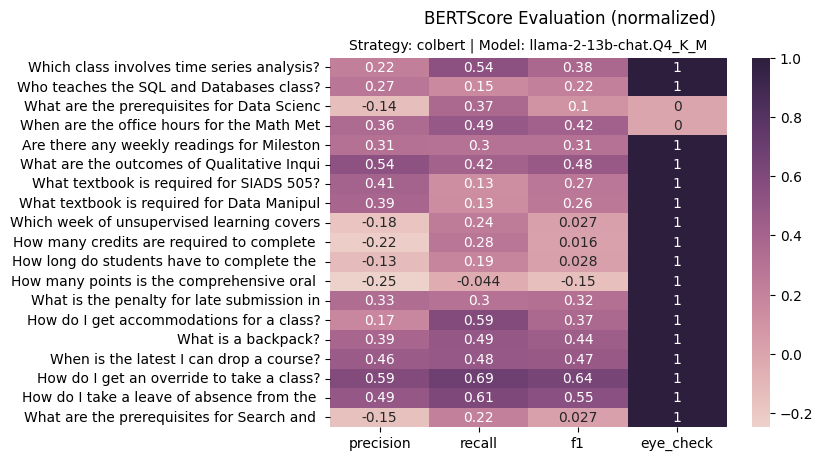

In [18]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()